# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('./content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O aerialseq.npy
if not os.path.exists('./content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O antseq.npy

--2025-09-26 22:00:54--  https://www.cs.cmu.edu/~deva/data/aerialseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160128 (88M)
Saving to: ‘aerialseq.npy’

aerialseq.npy       100%[===================>]  87.89M   554KB/s    in 2m 49s  

2025-09-26 22:03:45 (532 KB/s) - ‘aerialseq.npy’ saved [92160128/92160128]

--2025-09-26 22:03:45--  https://www.cs.cmu.edu/~deva/data/antseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)
Saving to: ‘antseq.npy’

antseq.npy          100%[===================>]  62.50M   574KB/s    in 1m 55s  

2025-09-26 22:05:41 (556 KB/s) - ‘antseq.npy’ saved [65536128/65536128]



# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [18]:
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import affine_transform

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    height, width = It.shape
    p = np.zeros(6)
    rows = np.arange(height)
    columns = np.arange(width)

    x, y = np.meshgrid(rows, columns, indexing='ij')
    x = x.flatten()
    y = y.flatten()
    It_flat = It.flatten()

    for i in range(num_iters):
        It1_warp = affine_transform(It1, M, mode='nearest')
        error = It_flat - It1_warp.flatten()

        Ix, Iy = np.gradient(It1_warp)
        Ix = Ix.flatten()
        Iy = Iy.flatten()

        A = np.vstack((Ix * x, Iy * x, Ix * y, Iy * y, Ix, Iy)).T

        hessian = A.T @ A
        delta_p = np.linalg.inv(hessian) @ A.T @ error

        p += delta_p
        M = np.array([[1.0 + p[0], p[2], p[4]], [p[1], 1.0 + p[3], p[5]]])

        if np.linalg.norm(delta_p) < threshold:
            break

    # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

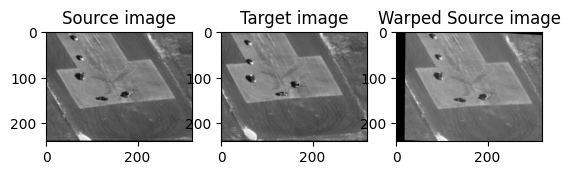

In [14]:
import cv2

num_iters = 100
threshold = 0.02
seq = np.load("aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [21]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    H, W = It.shape

    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    # warped_img = affine_transform(It1, M)
    warped_It1 = cv2.warpAffine(It1, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    valid_mask = cv2.warpAffine(np.ones_like(It1), M, (W, H), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    difference = np.abs(It - warped_It1) * valid_mask

    mask = (difference > tolerance)
    mask = binary_dilation(mask, iterations=2, brute_force=True).astype(mask.dtype)
    mask = binary_erosion(mask, iterations=2, brute_force=True).astype(mask.dtype)

    # ===== End of code =====

    return mask.astype(bool)

## Q3.3: Tracking with affine motion (10 points)

In [16]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:, :, 0]
    masks = []

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:, :, i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [19]:
seq = np.load("antseq.npy")

# NOTE: feel free to play with these parameters
#TUNED PARAMETERS - ITERATION FOR EROSION AND DILATION = 1
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:13<00:00,  9.48it/s]



Ant Sequence takes 13.120779 seconds


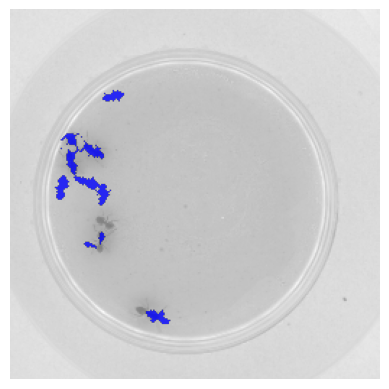

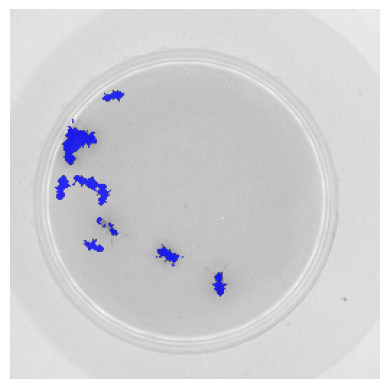

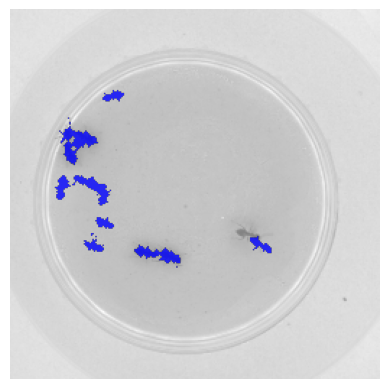

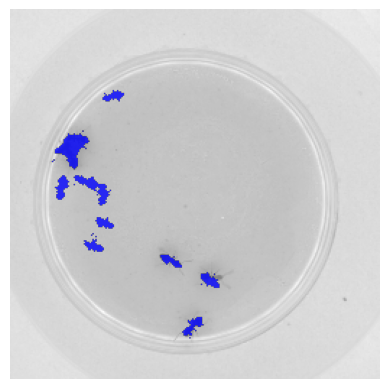

In [20]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [22]:
seq = np.load("aerialseq.npy")

# NOTE: feel free to play with these parameters
#TUNED PARAMETERS - ITERATION FOR EROSION AND DILATION = 2
num_iters = 1000
threshold = 0.01
tolerance = 0.3

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAriel Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [30:13<00:00, 12.17s/it]


Ariel Sequence takes 1813.514410 seconds


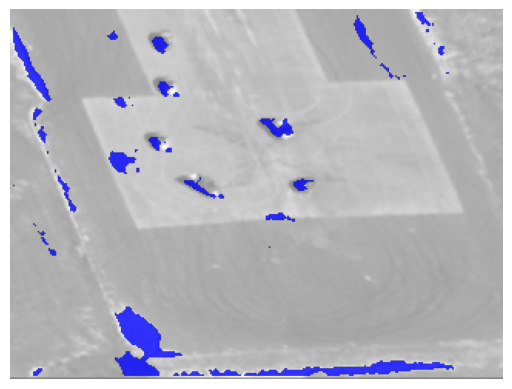

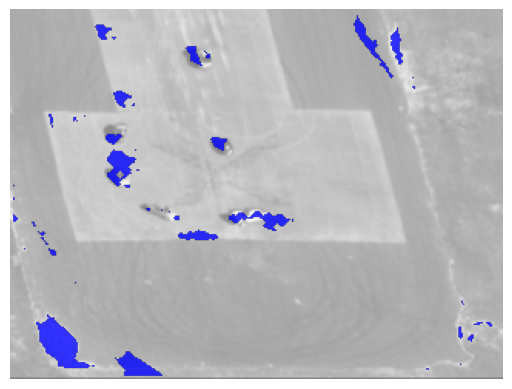

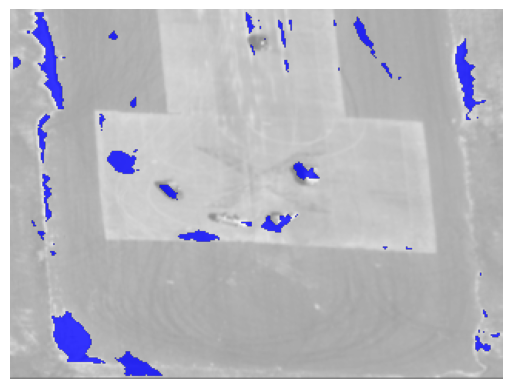

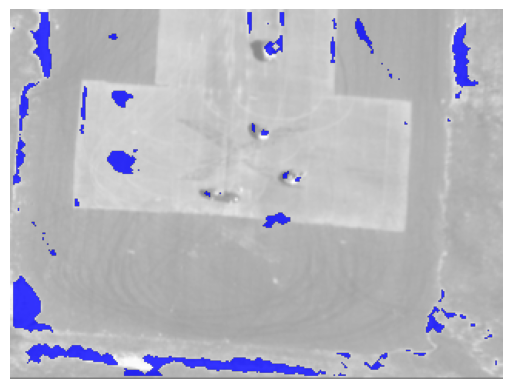

In [12]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

This is the end of this notebook.